In [1]:
import shutil
import os
import business_logic
from business_logic import RoomManager
from data_access import RoomDataAccess, AddressDataAccess
from model import Booking

source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file) #Copy original DB first to always start fresh.
os.environ["DB_FILE"] = db_file

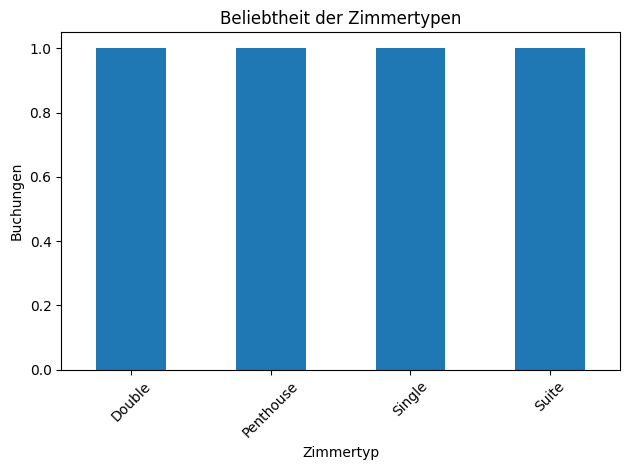

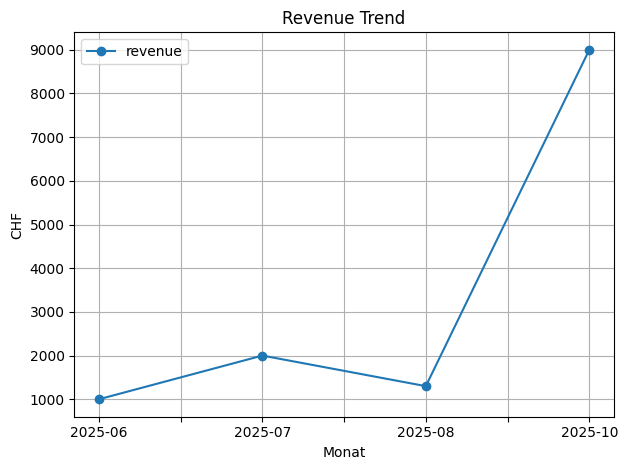

DatabaseError: Execution failed on sql '
    SELECT AVG(age) AS avg_age FROM Guest
    ': no such column: age

In [14]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

with sqlite3.connect(db_file) as conn:
    query = """
    SELECT rt.description AS room_type, COUNT(*) AS total_bookings
    FROM Booking b
    JOIN Room r ON b.room_id = r.room_id
    JOIN Room_Type rt ON r.type_id = rt.type_id
    WHERE b.is_cancelled = 0
    GROUP BY rt.description
    """

    df = pd.read_sql_query(query, conn)

# Visualisierung
df.plot(kind="bar", x="room_type", y="total_bookings", legend=False, title="Beliebtheit der Zimmertypen")
plt.ylabel("Buchungen")
plt.xlabel("Zimmertyp")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


with sqlite3.connect(db_file) as conn:
    query = """
    SELECT strftime('%Y-%m', check_in_date) AS month, SUM(total_amount) AS revenue
    FROM Booking
    WHERE is_cancelled = 0
    GROUP BY month
    ORDER BY month
    """
    df = pd.read_sql_query(query, conn)


df.plot(kind="line", x="month", y="revenue", marker='o', title="Revenue Trend")
plt.ylabel("CHF")
plt.xlabel("Monat")
plt.grid(True)
plt.tight_layout()
plt.show()

with sqlite3.connect(db_file) as conn:
    query = """
    SELECT AVG(age) AS avg_age FROM Guest
    """
    df = pd.read_sql_query(query, conn)
    conn.close()

    print("Durchschnittsalter der Gäste:", round(df['avg_age'][0], 1))


In [54]:
def test(s: str):
    print(s)

test(1)

1


 Als Gast möchte ich die verfügbaren Hotels durchsuchen, damit
ich dasjenige auswählen kann, welches meinen Wünschen
entspricht. Wünsche sind:
1.1. Ich möchte alle Hotels in einer Stadt durchsuchen,
damit ich das Hotel nach meinem bevorzugten Standort
(Stadt) auswählen kann.

In [11]:
from business_logic.hotel_manager import HotelManager
import shutil

# Datenbank vorbereiten
source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file)

# HotelManager instanziieren
hotel_mgr = HotelManager()

try:
    city_input = input("Stadt eingeben: ").strip()


    hotels = hotel_mgr.search_hotels_by_city(city_input)
    if not hotels:
        print(f"Keine Hotels in {city_input} gefunden.")
    else:
        for h in hotels:
            print(f"Hotelname: {h.name} in {city_input}")

except ValueError as e:
    print("Fehler bei der Eingabe:", e)



Hotelname: Grand Hotel National in luzern


1.2. Ich möchte alle Hotels in einer Stadt nach der
Anzahl der Sterne (z.B. mindestens 4 Sterne) durchsuchen.

In [13]:

from business_logic.hotel_manager import HotelManager
from utils.Inputs import validate_search_inputs_1_2

import shutil

source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file)

hotel_mgr = HotelManager()

try:
    city_input = input("Stadt eingeben: ")
    stars_input = int(input("Sterne eingeben: "))

    validate_search_inputs_1_2(city_input, stars_input)


    hotels = hotel_mgr.search_hotels_by_city_and_stars(city_input, stars_input)
    for h in hotels:
        print(f"Hotel Name: {h.name} in der Stadt {city_input},\nAnzahl Sterne: {h.stars}")

except ValueError as e:
    print("Fehler:", e)


Hotel Name: Grand Hotel National in der Stadt Luzern,
Anzahl Sterne: 5


1.3. Ich möchte alle Hotels in einer Stadt durchsuchen,
die Zimmer haben, die meiner Gästezahl entsprechen (nur 1
Zimmer pro Buchung)

In [14]:

from business_logic.hotel_manager import HotelManager

from utils.Inputs import validate_search_inputs_1_3
import traceback
import shutil

source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file)


hotel_mgr = HotelManager()


try:
    city_input = input("Stadt eingeben: ")
    stars_input = int(input("Sterne eingeben: "))
    guests_input = int(input("Anzahl Gäste eingeben: "))

    validate_search_inputs_1_3(city_input, stars_input, guests_input)

    # Debug: vor der Suche ausgeben
    print(f"Suche Hotels in {city_input} mit {stars_input} Sternen und mindestens {guests_input} Gästen pro Zimmer...")

    hotels = hotel_mgr.search_hotels_for_guests(city_input, stars_input, guests_input)

    # Debug: prüfen, ob Ergebnisse da sind
    if not hotels:
        print("Keine Hotels gefunden. Mögliche Ursachen:")
        print("- Keine Hotels in der Stadt mit dieser Sternezahl.")
        print("- Keine Zimmer mit ausreichend Kapazität (max_guests).")
        print("- Fehler in der SQL-Abfrage oder Datenbankverbindung.")
    else:
        for h in hotels:
            # Da hotel.room_type eine Liste ist, besser erst prüfen, z.B. erstes Element nehmen
            if h._Hotel__room_type:  # Zugriff auf private Liste, besser Property nutzen falls vorhanden
                max_guests = h._Hotel__room_type[0].max_guests
            else:
                max_guests = "keine Raumtypen gefunden"

            print(f"Hotel Name: {h.name} in der Stadt {city_input},\nAnzahl Sterne: {h.stars}\nAnzahl Gäste: {max_guests}\n")

except ValueError as e:
    print("Fehler:", e)
except Exception:
    print("Unerwarteter Fehler:", )
    traceback.print_exc()

Suche Hotels in Luzern mit 5 Sternen und mindestens 2 Gästen pro Zimmer...
Hotel Name: Grand Hotel National in der Stadt Luzern,
Anzahl Sterne: 5
Anzahl Gäste: 5



1.4. Ich möchte alle Hotels in einer Stadt durchsuchen,
die während meines Aufenthaltes ("von" (check_in_date)
und "bis" (check_out_date)) Zimmer zur Verfügung haben,
damit ich nur relevante Ergebnisse sehe.

In [15]:
from business_logic.hotel_manager import HotelManager
from utils.Inputs import validate_search_inputs_1_1
from datetime import datetime


import shutil
source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file) #Copy original DB first to always start fresh.


hotel_mgr = HotelManager()

try:
    city_input = input("Stadt eingeben: ")
    check_in = input("Check-in Datum eingeben (YYYY-MM-DD): ")
    check_out = input("Check-out Datum eingeben (YYYY-MM-DD): ")


    check_in_date = datetime.strptime(check_in, "%Y-%m-%d")
    check_out_date = datetime.strptime(check_out, "%Y-%m-%d")
    nights = (check_out_date - check_in_date).days


    if nights <= 0:
        raise ValueError("Nights must be positive")

    validate_search_inputs_1_1(city_input)


    hotels = hotel_mgr.search_hotel_Aufenthalt(city_input, check_in_date, check_out_date)

    if not hotels:
        print("Keine verfügbaren Hotels für den angegebenen Zeitraum.")
    for h in hotels:
        for room in h.rooms:
            total_price = room.price_per_night * nights
            print(f"Hotel Name: {h.name} in der Stadt {h.address.city}")
            print(f"  Beschreibung des Zimmers: {room.room_type.description}")
            print(f"  Maximale Anzahl Gäste: {room.room_type.max_guests}")
            print(f"  Preis pro Nacht: {room.price_per_night:.2f} CHF")
            print(f"  Gesamtpreis für {nights} Nächte: {total_price:.2f} CHF\n")

except ValueError as e:
    print("Fehler:", e)

Hotel Name: Grand Hotel National in der Stadt Luzern
  Beschreibung des Zimmers: Family Room
  Maximale Anzahl Gäste: 5
  Preis pro Nacht: 900.00 CHF
  Gesamtpreis für 2 Nächte: 1800.00 CHF



1.5. Ich möchte Wünsche kombinieren können, z.B. die
verfügbaren Zimmer zusammen mit meiner Gästezahl und der
mindest Anzahl Sterne.

In [16]:
from business_logic.hotel_manager import HotelManager
from utils.Inputs import validate_search_inputs_1_1
from datetime import datetime
import traceback


import shutil
source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file) #Copy original DB first to always start fresh.

hotel_mg = HotelManager()

try:

    city_input = input("Stadt eingeben: ")
    check_in = input("Check-in Datum eingeben (YYYY-MM-DD): ")
    check_out = input("Check-out Datum eingeben (YYYY-MM-DD): ")
    min_stars = int(input("Minimale Anzahl Sterne: "))
    guest_count = int(input("Maximale Anzahl Gäste: "))

    # Umwandlung der Datumsstrings in datetime-Objekte
    check_in_date = datetime.strptime(check_in, "%Y-%m-%d")
    check_out_date = datetime.strptime(check_out, "%Y-%m-%d")
    nights = (check_out_date - check_in_date).days

    if nights <= 0:
        raise ValueError("Check-out Datum muss nach dem Check-in liegen.")

    validate_search_inputs_1_1(city_input)


    hotels = hotel_mgr.search_hotel_combinated(
        city=city_input,
        check_in_date=check_in,
        check_out_date=check_out,
        min_stars=min_stars,
        max_guests=guest_count
    )

    for h in hotels:
        for room in h.rooms:
            total_price = room.price_per_night * nights
            print(f"Hotel: {h.name} ({h.stars}) in {h.address.city}")
            print(f"  Zimmer: {room.room_type.description} ({room.room_type.max_guests} Gäste)")
            print(f"  Preis pro Nacht: {room.price_per_night:.2f} CHF")
            print(f"  Gesamtpreis für {nights} Nächte: {total_price:.2f} CHF")
            print()

except ValueError as e:
    print("Fehler:", e)




Hotel: Grand Hotel National (5) in Luzern
  Zimmer: Family Room (5 Gäste)
  Preis pro Nacht: 900.00 CHF
  Gesamtpreis für 4 Nächte: 3600.00 CHF



1.6. Ich möchte die folgenden Informationen pro Hotel
sehen: Name, Adresse, Anzahl der Sterne.

In [17]:
from business_logic.hotel_manager import HotelManager
import pandas as pd
import shutil

source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file)

hotel_mgr = HotelManager()

try:


    hotels = hotel_mgr.zeige_Information_pro_Hotel()

    data = []
    for hotel in hotels:
        data.append({
            "Hotel-ID": hotel.hotel_id,
            "Name": hotel.name,
            "Sterne": hotel.stars,
            "Straße": hotel.address.street,
            "Stadt": hotel.address.city,
            "PLZ": hotel.address.zip_code
        })

    df = pd.DataFrame(data)
    print(df)

except ValueError as e:
    print("Fehler:", e)
except Exception as ex:
    print("Unerwarteter Fehler:", ex)


   Hotel-ID                            Name  Sterne             Straße  \
0         1               Hotel Baur au Lac       5   Bahnhofstrasse 1   
1         2  Four Seasons Hôtel des Bergues       5    Rue du Rhône 42   
2         3            Grand Hotel National       5  Pilatusstrasse 15   
3         4                 Bellevue Palace       5      Marktgasse 59   
4         5                  Les Trois Rois       5    Freiestrasse 10   

    Stadt   PLZ  
0  Zürich  8001  
1  Genève  1204  
2  Luzern  6003  
3    Bern  3011  
4   Basel  4051  


Als Gast möchte ich Details zu verschiedenen Zimmertypen
(Single, Double, Suite usw.), die in einem Hotel verfügbar
sind, sehen, einschliesslich der maximalen Anzahl von Gästen
für dieses Zimmer, Beschreibung, Preis und Ausstattung, um eine
fundierte Entscheidung zu treffen.




In [ ]:
from business_logic.hotel_manager import HotelManager
from model.room_type import RoomType
from model.room import Room
from datetime import datetime

from utils.Inputs import validate_search_inputs_1_1
import traceback
import shutil
source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file) #Copy original DB first to always start fresh.


hotel_mgr = HotelManager()



try:
    city_input = input("Stadt eingeben: ")
    check_in = input("Check-in Datum eingeben (YYYY-MM-DD): ")
    check_out = input("Check-out Datum eingeben (YYYY-MM-DD): ")


    check_in_date = datetime.strptime(check_in, "%Y-%m-%d")
    check_out_date = datetime.strptime(check_out, "%Y-%m-%d")
    nights = (check_out_date - check_in_date).days




    if nights <= 0:
        raise ValueError("Nights must be positive")


    validate_search_inputs_1_1(city_input)

    hotels = hotel_mgr.search_hotel_print_rooms(city_input)
    for h in hotels:
        for room in h.rooms:
            total_price = room.price_per_night * nights
            print(f"Hotel Name: {h.name} in der Stadt {h.address.city}")
            print(f"  Beschreibung des Zimmers: {room.room_type.description}")
            print(f"  Maximale Anzahl Gäste: {room.room_type.max_guests}")
            print(f"  Preis pro Nacht: {room.price_per_night:.2f} CHF")
            print(f"  Gesamtpreis für {nights} Nächte: {total_price:.2f} CHF")
            print()

except ValueError as e:
    print("Fehler:", e)


2.1. Ich möchte die folgenden Informationen pro Zimmer
sehen: Zimmertyp, max. Anzahl der Gäste, Beschreibung,
Ausstattung, Preis pro Nacht und Gesamtpreis.

In [2]:
from business_logic.hotel_manager import HotelManager
from model.room_type import RoomType
from model.room import Room
from datetime import datetime
import pandas as pd
import shutil


source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file) #Copy original DB first to always start fresh.


hotel_mgr = HotelManager()

try:

    nights_input = int(input("Bitte Anzahl Nächte eingeben: "))


    nights = (nights_input)
    if nights <= 0:
        raise ValueError("Anzahl Nächte muss größer als 0 sein.")


    zimmer_liste = hotel_mgr.show_Information_per_room(nights=nights)

    df = pd.DataFrame(zimmer_liste)
    print(df)

except ValueError as e:
    print("Fehler:", e)
except Exception as ex:
    print("Unerwarteter Fehler:", ex)

   Zimmer-ID    Zimmertyp  Max. Gäste       Ausstattung  \
0          1       Single           1          WiFi, TV   
1          2       Double           2              WiFi   
2          3        Suite           4  Air Conditioning   
3          4  Family Room           5          Mini Bar   
4          5    Penthouse           6             Keine   

   Preis pro Nacht (CHF)  Gesamtpreis für 3 Nächte (CHF)  
0                  250.0                           750.0  
1                  400.0                          1200.0  
2                  650.0                          1950.0  
3                  900.0                          2700.0  
4                 1500.0                          4500.0  


2.2. Ich möchte nur die verfügbaren Zimmer sehen, sofern
ich meinen Aufenthalt (von – bis) spezifiziert habe.

In [ ]:
from business_logic.hotel_manager import HotelManager
from datetime import datetime


import shutil
source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file) #Copy original DB first to always start fresh.


hotel_mgr = HotelManager()

try:

    city_input = input("Stadt eingeben: ").strip()
    check_in = input("Check-in Datum eingeben (YYYY-MM-DD): ").strip()
    check_out = input("Check-out Datum eingeben (YYYY-MM-DD): ").strip()
    nights = (datetime.strptime(check_out, "%Y-%m-%d") - datetime.strptime(check_in, "%Y-%m-%d")).days

    if nights <= 0:
        raise ValueError("Check-out-Datum muss nach dem Check-in-Datum liegen.")
    hotels =(hotel_mgr.search_hotel_print_rooms(city_input, check_in, check_out))


    if not hotels:
        print("Keine verfügbaren Zimmer in dieser Stadt im angegebenen Zeitraum gefunden.")
    else:
        for h in hotels:
            print(f"Hotel: {h.name} ({h.address.city})")
            for room in h.rooms:
                total_price = room.price_per_night * nights
                print(f"  → Zimmertyp: {room.room_type.description}")
                print(f"     Max. Gäste: {room.room_type.max_guests}")
                print(f"     Preis pro Nacht: {room.price_per_night:.2f} CHF")
                print(f"     Gesamtpreis ({nights} Nächte): {total_price:.2f} CHF\n")

except ValueError as e:
    print("Fehler:", e)
except Exception as e:
    print("Unerwarteter Fehler:", e)



3.1 Ich möchte neue Hotels zum System hinzufügen

In [3]:
from business_logic.hotel_manager import HotelManager
from business_logic.address_manager import AddressManager

import shutil
source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file) #Copy original DB first to always start fresh.


hotel_mgr = HotelManager()
address_mgr= AddressManager()

try:
    name = input("Hotelname eingeben: ").strip()
    stars_input = input("Sterne eingeben (1-5): ").strip()
    stars = int(stars_input)

     # DB-Zugriff vorbereiten
    street = input("Straße eingeben: ").strip()
    city = input("Stadt eingeben: ").strip()
    zip_code = input("PLZ eingeben: ").strip()


    # Hotel erstellen
    address = address_mgr.create_new_address(street, city, zip_code)
    hotel = hotel_mgr.create_new_hotel(name, stars, address)

    if hotel:
        print(f"Hotel '{hotel.name}' mit ID {hotel.hotel_id} wurde erfolgreich erstellt.")
    else:
        print("Hotel konnte nicht erstellt werden.")

except ValueError as ve:
    print(f"Eingabefehler: {ve}")
except Exception as e:
    print(f"Unerwarteter Fehler: {e}")



Hotel 'National' mit ID 6 wurde erfolgreich erstellt.


3.2 Ich möchte Hotels aus dem System entfernen

In [4]:

from business_logic.hotel_manager import HotelManager
from business_logic.address_manager import AddressManager
import shutil
source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file) #Copy original DB first to always start fresh.


hotel_mgr = HotelManager()
address_mgr= AddressManager()




try:
    hotel_id_input = input("Hotel-ID eingeben, das gelöscht werden soll: ").strip()
    hotel_id = int(hotel_id_input)
    success = hotel_mgr.delete_hotel(hotel_id)

    if success:
        print(f"Hotel mit ID {hotel_id} wurde erfolgreich gelöscht.")
    else:
        print(f"Hotel mit ID {hotel_id} wurde nicht gefunden oder konnte nicht gelöscht werden.")

except ValueError as ve:
    print(f"Eingabefehler: {ve}")
except Exception as e:
    print(f"Unerwarteter Fehler: {e}")



Hotel mit ID 1 wurde erfolgreich gelöscht.


Hotel entfernen 3.2

In [16]:
from business_logic.hotel_manager import HotelManager
from business_logic.address_manager import AddressManager
import ipywidgets as widgets
from IPython.display import display, clear_output


import shutil
source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file)




hotel_mgr = HotelManager()
address_mgr= AddressManager()

hotel_id_input = widgets.IntText(description="Hotel-ID:")
delete_hotel_btn = widgets.Button(description="Hotel löschen")
output = widgets.Output()



def delete_hotel(b):
    with output:
        clear_output()
        try:
            hotel_id = int(hotel_id_input.value)
            if hotel_id <= 0:
                print("Bitte eine gültige Hotel-ID (positive Zahl) eingeben.")
                return

            success = hotel_mgr.delete_hotel(hotel_id)
            if success:
                print(f"Hotel mit ID {hotel_id} wurde gelöscht.")
            else:
                print(f"Kein Hotel mit ID {hotel_id} gefunden.")

        except ValueError:
            print("Ungültige Eingabe. Bitte geben Sie eine gültige ganze Zahl für die Hotel-ID ein.")
        except Exception as e:
            print(f"Fehler bei der Löschung: {e}")



delete_hotel_btn.on_click(delete_hotel)


display(widgets.HTML("<b>Hotel löschen</b>"))
display(hotel_id_input, delete_hotel_btn)

display(output)


HTML(value='<b>Hotel löschen</b>')

IntText(value=0, description='Hotel-ID:')

Button(description='Hotel löschen', style=ButtonStyle())

Output()

3.2 Mit Eingabebereich

3.3 Ich möchte die Informationen bestimmter Hotels
aktualisieren, z. B. den Namen, die Sterne usw.

In [5]:
from business_logic.hotel_manager import HotelManager
from business_logic.address_manager import AddressManager
import shutil

source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file) #Copy original DB first to always start fresh.


hotel_mgr = HotelManager()
address_mgr= AddressManager()


try:
    hotel_id = int(input("Hotel-ID zum Aktualisieren: "))
    name = input("Neuer Hotelname: ").strip()
    stars = int(input("Neue Sterneanzahl (1–5): "))
    address_id = int(input("Neue Address-ID: "))

    if hotel_mgr.update_hotel(hotel_id, name, stars, address_id):
        print(f"Hotel mit ID {hotel_id} wurde erfolgreich aktualisiert.")
    else:
        print(f"Hotel mit ID {hotel_id} wurde nicht gefunden oder konnte nicht aktualisiert werden.")

except ValueError as ve:
    print(f"Eingabefehler: {ve}")
except Exception as e:
    print(f"Unerwarteter Fehler: {e}")


Hotel mit ID 1 wurde erfolgreich aktualisiert.


Aufgabe 3 in einem Feld:  Als Admin des Buchungssystems möchte ich die Möglichkeit haben, Hotelinformationen zu pflegen, um aktuelle Informationen im System zu haben.
3.1. Ich möchte neue Hotels zum System hinzufügen
3.2. Ich möchte Hotels aus dem System entfernen
3.3. Ich möchte die Informationen bestimmter Hotels

In [13]:
from business_logic.hotel_manager import HotelManager
from business_logic.address_manager import AddressManager
import ipywidgets as widgets
from IPython.display import display, clear_output


import shutil
source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file)



hotel_mgr = HotelManager()
address_mgr= AddressManager()

output = widgets.Output()



##Datenverwalten
street_input = widgets.Text(description="Straße:")
city_input = widgets.Text(description="Stadt:")
zip_code_input = widgets.Text(description="PLZ:")

name_input = widgets.Text(description="Hotelname:")
stars_input = widgets.IntText(description="Sterne:")

create_address_btn = widgets.Button(description="Adresse erstellen")
create_hotel_btn = widgets.Button(description="Hotel erstellen")

output = widgets.Output()

address_id_holder = {}


def create_new_address(b):
    try:
        address = address_mgr.create_new_address(street_input.value, city_input.value, zip_code_input.value)
        address_id_holder["address"] = address
        with output:
            clear_output()
            print("Adresse wurde erfolgreich erstellt mit ID: {address.adresse_id}")
    except Exception as e:
        with output:
            clear_output()
            print(f"Fehler bei Adresse: {e}")

def create_new_hotel(b):
    try:
        if "address" not in address_id_holder:
            raise ValueError("Bitte zuerst eine Adresse erstellen.")
        address = address_id_holder["address"]
        hotel = hotel_mgr.create_new_hotel(
            name=name_input.value,
            stars=stars_input.value,
            address=address
        )
        with output:
            clear_output()
            print(f"Hotel '{hotel.name}' wurde erstellt.")
    except Exception as e:
        with output:
            clear_output()
            print(f"Fehler bei Hotel: {e}")



create_address_btn.on_click(create_new_address)
create_hotel_btn.on_click(create_new_hotel)

display(widgets.HTML("<b>Addresse erstellen </b>"))
display(street_input, city_input, zip_code_input, create_address_btn)

display(widgets.HTML("<b>Hotel erstellen</b>"))
display(name_input, stars_input, create_hotel_btn)

display(output)





HTML(value='<b>Addresse erstellen </b>')

Text(value='', description='Straße:')

Text(value='', description='Stadt:')

Text(value='', description='PLZ:')

Button(description='Adresse erstellen', style=ButtonStyle())

HTML(value='<b>Hotel erstellen</b>')

Text(value='', description='Hotelname:')

IntText(value=0, description='Sterne:')

Button(description='Hotel erstellen', style=ButtonStyle())

Output()

4. Als Gast möchte ich ein Zimmer in einem bestimmten Hotel
buchen, um meinen Urlaub zu planen. Mit bestehendem Gast

In [6]:
from business_logic.hotel_manager import HotelManager
from business_logic.room_manager import RoomManager
from business_logic.booking_manager import BookingManager
from business_logic.guest_manager import GuestManager
import pandas as pd
import shutil
import time
from datetime import datetime

# Datenbank vorbereiten
source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file)

# Manager-Instanzen
hotel_mgr = HotelManager()
room_mgr = RoomManager()
booking_mgr = BookingManager()
guest_mgr = GuestManager()

try:
    # 1. Hotelsuche
    city_input = input("Stadt eingeben: ").strip()
    stars_input = int(input("Sterne eingeben (1-5): ").strip())


    hotels = hotel_mgr.search_hotels_by_city_and_stars(city_input, stars_input)
    if not hotels:
        print(f"Keine Hotels in {city_input} mit {stars_input} Stern(en) gefunden.")
        exit()

    # 2. Hotelübersicht anzeigen
    hotel_data = []
    for idx, h in enumerate(hotels, start=1):
        hotel_data.append({
            "Nr": idx,
            "Hotelname": h.name,
            "Sterne": h.stars,
            "Stadt": h.address.city if h.address else "n/a"
        })
    df_hotels = pd.DataFrame(hotel_data)
    print("\nGefundene Hotels:")
    print(df_hotels.to_string(index=False))
    time.sleep(3)

    # 3. Hotel auswählen
    selected_index = int(input("\nHotel auswählen (Nr): ").strip())
    selected_hotel = hotels[selected_index - 1]

    # 4. Zimmer anzeigen
    rooms = room_mgr.read_rooms_by_hotel(selected_hotel)
    if not rooms:
        print("Keine Zimmer im gewählten Hotel verfügbar.")
        exit()

    room_data = []
    for r in rooms:
        price_str = f"{r.price_per_night:.2f} CHF" if isinstance(r.price_per_night, (float, int)) else "n/a"
        room_data.append({
            "Zimmer-ID": r.room_id,
            "Zimmernummer": r.room_number,
            "Preis/Nacht": price_str
        })
    df_rooms = pd.DataFrame(room_data)
    print("\nZimmerübersicht:")
    print(df_rooms.to_string(index=False))
    time.sleep(3)
    # 5. Buchung starten
    buchung = input("\nMöchten Sie ein Zimmer buchen? (ja/nein): ").strip().lower()
    if buchung == "nein":
        print("Buchung abgebrochen.")
        exit()
    else:
        # 6. Buchungsdaten eingeben
        selected_room_id = int(input("Zimmer-ID eingeben: ").strip())
        check_in_str = input("Check-in (YYYY-MM-DD): ").strip()
        check_out_str = input("Check-out (YYYY-MM-DD): ").strip()
        guest_id = int(input("Ihre Gast-ID: ").strip())

        check_in_date = datetime.strptime(check_in_str, "%Y-%m-%d").date()
        check_out_date = datetime.strptime(check_out_str, "%Y-%m-%d").date()

        if check_in_date >= check_out_date:
            raise ValueError("Check-out-Datum muss nach dem Check-in-Datum liegen.")

        guest = guest_mgr.read_guest_by_id(guest_id)
        room = room_mgr.get_room_by_id(selected_room_id)


        if guest is None:
            raise ValueError(f"Kein Gast mit ID {guest_id} gefunden.")
        if room is None:
            raise ValueError(f"Kein Zimmer mit ID {selected_room_id} gefunden.")

        # 6c. Preis berechnen
        nights = (check_out_date - check_in_date).days
        total_amount = room.price_per_night * nights

        # 7. Buchung durchführen
        booking = booking_mgr.create_new_booking(
            check_in_date=check_in_date,
            check_out_date=check_out_date,
            is_cancelled=False,
            total_amount=total_amount,
            guest=guest,
            room=room
        )
        print(f"\n Buchung erfolgreich! Buchungsnummer: {booking.booking_id}, Gäste_Id: {booking.guest.guest_id} Nachname: {booking.guest.last_name} Vorname: {booking.guest.first_name}")


except Exception as e:
    print("\nFehler bei der Verarbeitung:", e)


DEBUG: city in DAO = BERN, stars = 5
DEBUG SQL PARAMS: BERN, 5

Gefundene Hotels:
 Nr       Hotelname  Sterne Stadt
  1 Bellevue Palace       5  Bern
<class 'int'>

Zimmerübersicht:
 Zimmer-ID Zimmernummer Preis/Nacht
         5          401 1500.00 CHF
DEBUG: is_cancelled type/value <class 'bool'> False
DEBUG: Returning Booking with is_cancelled False

 Buchung erfolgreich! Buchungsnummer: 6, Gäste angaben: 1 nachname: Müller vorname: Hans


4.2 Buchen als unbekannter Gast


In [3]:

from business_logic.hotel_manager import HotelManager
from business_logic.room_manager import RoomManager
from business_logic.booking_manager import BookingManager
from business_logic.guest_manager import GuestManager
import pandas as pd
import shutil
import time
import traceback
from datetime import datetime

# Datenbank vorbereiten
source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file)

# Manager-Instanzen
hotel_mgr = HotelManager()
room_mgr = RoomManager()
booking_mgr = BookingManager()
guest_mgr = GuestManager()

try:
    # 1. Hotelsuche
    city_input = input("Stadt eingeben: ").strip()
    stars_input = int(input("Sterne eingeben (1-5): ").strip())

    hotels = hotel_mgr.search_hotels_by_city_and_stars(city_input, stars_input)
    if not hotels:
        print(f"Keine Hotels in {city_input} mit {stars_input} Stern(en) gefunden.")
        exit()

    # 2. Hotelübersicht anzeigen
    hotel_data = []
    for idx, h in enumerate(hotels, start=1):
        hotel_data.append({
            "Nr": idx,
            "Hotelname": h.name,
            "Sterne": h.stars,
            "Stadt": h.address.city if h.address else "n/a"
        })
    df_hotels = pd.DataFrame(hotel_data)
    print("\nGefundene Hotels:")
    print(df_hotels.to_string(index=False))
    time.sleep(3)

    # 3. Hotel auswählen
    selected_index = int(input("\nHotel auswählen (Nr): ").strip())
    selected_hotel = hotels[selected_index - 1]

    # 4. Zimmer anzeigen
    rooms = room_mgr.read_rooms_by_hotel(selected_hotel)
    if not rooms:
        print("Keine Zimmer im gewählten Hotel verfügbar.")
        exit()

    room_data = []
    for r in rooms:
        price_str = f"{r.price_per_night:.2f} CHF" if isinstance(r.price_per_night, (float, int)) else "n/a"
        room_data.append({
            "Zimmer-ID": r.room_id,
            "Zimmernummer": r.room_number,
            "Preis/Nacht": price_str
        })
    df_rooms = pd.DataFrame(room_data)
    print("\nZimmerübersicht:")
    print(df_rooms.to_string(index=False))
    time.sleep(3)


    # 5. Buchung starten
    buchung = input("\nMöchten Sie ein Zimmer buchen? (ja/nein): ").strip().lower()
    if buchung == "nein":
        print("Buchung abgebrochen.")
        exit()

    else:

        selected_room_id = int(input("Zimmer-ID eingeben: ").strip())
        check_in_str = input("Check-in (YYYY-MM-DD): ").strip()
        check_out_str = input("Check-out (YYYY-MM-DD): ").strip()

        from datetime import datetime, date
        check_in_date = datetime.strptime(check_in_str, "%Y-%m-%d").date()
        check_out_date = datetime.strptime(check_out_str, "%Y-%m-%d").date()



        # 6a. Gast-ID oder Neuanlage
        gast_neu = input("Sind Sie ein neuer Gast? (ja/nein): ").strip().lower()
        if gast_neu == "ja":
            vorname = input("Vorname: ").strip()
            nachname = input("Nachname: ").strip()
            email = input("E-Mail: ").strip()

            guest = guest_mgr.create_guest(first_name=vorname, last_name=nachname, email=email)
            print(f" Gast erfolgreich erstellt! Ihre Gast-ID: {guest.guest_id}")

        else:
            guest_id = int(input("Ihre Gast-ID: ").strip())
            guest = guest_mgr.read_guest_by_id(guest_id)
            if guest is None:
                raise ValueError(f" Kein Gast mit ID {guest_id} gefunden.")

        # 6b. Zimmer laden
        room = room_mgr.get_room_by_id(selected_room_id)
        if room is None:
            raise ValueError(f" Kein Zimmer mit ID {selected_room_id} gefunden.")

        # 6c. Verfügbarkeit prüfen (optional aber empfohlen)
        if not booking_mgr.is_room_available(room.room_id, check_in_date, check_out_date):
            raise Exception("Das Zimmer ist im gewählten Zeitraum nicht verfügbar.")

        # 6d. Preis berechnen
        nights = (check_out_date - check_in_date).days
        total_amount = room.price_per_night * nights

        # 7. Buchung durchführen
        booking = booking_mgr.create_new_booking(
            check_in_date=check_in_date,
            check_out_date=check_out_date,
            is_cancelled=False,
            total_amount=total_amount,
            guest=guest,
            room=room
        )
        print(f"\nBuchung erfolgreich! Buchungsnummer: {booking.booking_id}, Gäste_Id: {booking.guest.guest_id} Nachname: {booking.guest.last_name} Vorname: {booking.guest.first_name}")


except Exception as e:
    print("\nFehler bei der Verarbeitung:", e)


DEBUG: city in DAO = BERN, stars = 5
DEBUG SQL PARAMS: BERN, 5

Gefundene Hotels:
 Nr       Hotelname  Sterne Stadt
  1 Bellevue Palace       5  Bern
<class 'int'>

Zimmerübersicht:
 Zimmer-ID Zimmernummer Preis/Nacht
         5          401 1500.00 CHF
 Gast erfolgreich erstellt! Ihre Gast-ID: 6

Fehler bei der Verarbeitung: Check-in-Datum darf nicht in der Vergangenheit liegen.


5. Als Gast möchte ich nach meinem Aufenthalt eine Rechnung erhalten, damit ich einen Zahlungsnachweis habe. Hint: Fügt einen Eintrag in der «Invoice» Tabelle hinzu.

In [12]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import traceback
from datetime import date
from business_logic.booking_manager import BookingManager
from business_logic.guest_manager import GuestManager
from business_logic.hotel_manager import HotelManager
from business_logic.address_manager import AddressManager
from business_logic.room_manager import RoomManager
from business_logic.invoice_manager import InvoiceManager

from model.invoice import Invoice


DB_PATH = "database/working_db.db"

invoice_mgr = InvoiceManager()
guest_mgr = GuestManager()
booking_mgr = BookingManager()
guest_mgr = GuestManager()
room_mgr = RoomManager()




display(widgets.HTML("<h4>🧾 Rechnung auf Basis einer Buchung erstellen</h4>"))
booking_id_input = widgets.IntText(description="Buchung-ID:")
create_invoice_btn = widgets.Button(description="Rechnung generieren")
output = widgets.Output()

def display_invoice_html(invoice: Invoice):
    booking = invoice.booking
    guest = booking.guest
    room = booking.room

    html_content = f"""
    <div style="border: 2px solid #444; padding: 20px; max-width: 500px; font-family: Arial;">
        <h2 style="text-align: center; color: #2c3e50;">Hotelrechnung</h2>
        <p><strong>Rechnung-ID:</strong> {invoice.invoice_id}</p>
        <p><strong>Buchung-ID:</strong> {booking.booking_id}</p>
        <p><strong>Ausgestellt am:</strong> {invoice.issue_date}</p>
        <hr>
        <p><strong>Gast:</strong> {guest.first_name} {guest.last_name}</p>
        <p><strong>Zimmernummer:</strong> {room.room_number}</p>
        <p><strong>Check-in:</strong> {booking.check_in_date}</p>
        <p><strong>Check-out:</strong> {booking.check_out_date}</p>
        <p><strong>Preis pro Nacht:</strong> {room.price_per_night:.2f} CHF</p>
        <hr>
        <p><strong>Übernachtungen:</strong> {(booking.check_out_date - booking.check_in_date).days}</p>
        <p><strong>Gesamtbetrag:</strong> <span style="font-size: 1.2em; font-weight: bold;">{invoice.total_amount:.2f} CHF</span></p>
        <hr>
        <p style="text-align: center; color: #27ae60;"> Vielen Dank für Ihren Aufenthalt!</p>
    </div>
    """
    display(HTML(html_content))

def create_invoice_from_booking(b):
    with output:
        clear_output()
        try:
            booking_id = booking_id_input.value
            booking = booking_mgr.read_booking_by_id(booking_id)

            if not booking:
                raise ValueError(f"Buchung mit ID {booking_id} nicht gefunden.")

            # Rechnung erstellen
            invoice = invoice_mgr.create_new_invoice(
                booking=booking,
                total_amount=booking.total_amount,
                issue_date=date.today()
            )

            print("Rechnung erfolgreich erstellt!")
            display_invoice_html(invoice)

        except Exception as e:
            print("Fehler:")
            print(traceback.format_exc())

create_invoice_btn.on_click(create_invoice_from_booking)

display(booking_id_input, create_invoice_btn, output)



HTML(value='<h4>🧾 Rechnung auf Basis einer Buchung erstellen</h4>')

IntText(value=0, description='Buchung-ID:')

Button(description='Rechnung generieren', style=ButtonStyle())

Output()

In [1]:
import shutil
import os


source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file) #Copy original DB first to always start fresh.
os.environ["DB_FILE"] = db_file

6. Als Gast möchte ich meine Buchung stornieren, damit ich nicht
belastet werde, wenn ich das Zimmer nicht mehr benötige.
Hint: Sorgt für die entsprechende Invoice.

In [20]:
from business_logic.guest_manager import GuestManager
from business_logic.booking_manager import BookingManager
from business_logic.invoice_manager import InvoiceManager
from datetime import date
import traceback
import time

# Manager instanziieren
guest_mgr = GuestManager()
booking_mgr = BookingManager()
invoice_mgr = InvoiceManager()

try:
    # 1. Gast-ID eingeben
    guest_id = int(input("Geben Sie Ihre Gast-ID ein: ").strip())
    guest = guest_mgr.read_guest_by_id(guest_id)

    if not guest:
        print(f" Kein Gast mit ID {guest_id} gefunden.")
        exit()

    # 2. Aktive Buchungen laden (nicht storniert)
    active_bookings = [b for b in booking_mgr.read_all_bookings()
                       if b.guest.guest_id == guest_id and not b.is_cancelled]

    if not active_bookings:
        print("Keine aktiven Buchungen gefunden.")
        exit()

    # 3. Buchungen anzeigen
    print("\n Aktive Buchungen:")
    for idx, b in enumerate(active_bookings, start=1):
        print(f"Nummer: {idx}. Buchung-ID: {b.booking_id} | Check-in: {b.check_in_date} | "
              f"Check-out: {b.check_out_date} | Betrag: {b.total_amount:.2f} CHF")

    time.sleep(3)

    # 4. Auswahl zum Stornieren
    selection = int(input("\nWelche Buchung möchten Sie stornieren? (Nr eingeben): ").strip()) - 1
    if selection < 0 or selection >= len(active_bookings):
        raise IndexError(f"Ungültige Auswahl. Bitte Zahl zwischen 1 und {len(active_bookings)} eingeben.")

    selected_booking = active_bookings[selection]

    # 5. Buchung stornieren
    updated_booking = booking_mgr.cancel_booking(selected_booking)

    # 6. Rechnung erzeugen
    invoice = invoice_mgr.create_new_invoice(
        booking=updated_booking,
        total_amount=updated_booking.total_amount,
        issue_date=date.today()
    )

    # 7. Bestätigung
    print("\nBuchung wurde erfolgreich storniert.")
    print(f"Rechnung-ID: {invoice.invoice_id} | Stornogebühr: {invoice.total_amount:.2f} CHF")

except Exception as e:
    print("Fehler aufgetreten:", e)
    traceback.print_exc()



 Aktive Buchungen:
1. Buchung-ID: 6 | Check-in: 2025-10-12 | Check-out: 2025-10-14 | Betrag: 1800.00 CHF

Buchung wurde erfolgreich storniert.
Rechnung-ID: 10 | Stornogebühr: 360.00 CHF


7. Als Gast möchte ich eine dynamische Preisgestaltung auf der Grundlage der Nachfrage sehen, damit ich ein Zimmer zum besten Preis buchen kann. Hint: Wendet in der Hochsaison höhere und in der Nebensaison niedrigere Tarife an.

In [2]:
from datetime import datetime

from business_logic.hotel_manager import HotelManager
from business_logic.room_manager import RoomManager
import pandas as pd


import shutil
source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file)

hotel_mgr = HotelManager()
room_mgr = RoomManager()

check_in_date = input("Check-in Datum (YYYY-MM-DD): ").strip()
check_out_date = input("Check-out Datum (YYYY-MM-DD): ").strip()


preise = hotel_mgr.get_dynamic_room_prices(check_in_date, check_out_date)


df = pd.DataFrame(preise)
df

,Hotel,Zimmernummer,Zimmertyp,Max. Gäste,Basispreis (CHF),Dynamischer Preis (CHF),Stadt,Adresse,Check-in
0,Hotel Baur au Lac,101,Single,1,250.0,250.0,Zürich,"Bahnhofstrasse 1, 8001",2025-10-12
1,Hotel Baur au Lac,102,Double,2,400.0,400.0,Zürich,"Bahnhofstrasse 1, 8001",2025-10-12
2,Four Seasons Hôtel des Bergues,201,Suite,4,650.0,650.0,Genève,"Rue du Rhône 42, 1204",2025-10-12
3,Grand Hotel National,301,Family Room,5,900.0,900.0,Luzern,"Pilatusstrasse 15, 6003",2025-10-12
4,Bellevue Palace,401,Penthouse,6,1500.0,1500.0,Bern,"Marktgasse 59, 3011",2025-10-12


In [19]:
from datetime import datetime
from data_access.hotel_data_access import HotelDataAccess
import pandas as pd
import shutil
import traceback

# DB vorbereiten
source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file)
hotel_da = HotelDataAccess(db_file)

try:
    # Eingaben vom Nutzer
    city = input("In welcher Stadt möchten Sie übernachten? ").strip()
    check_in_str = input("Check-in Datum (YYYY-MM-DD): ").strip()
    check_out_str = input("Check-out Datum (YYYY-MM-DD): ").strip()
    guests = int(input("Wie viele Gäste reisen an? ").strip())

    # Datumsumwandlung & Validierung
    check_in_date = datetime.strptime(check_in_str, "%Y-%m-%d").date()
    check_out_date = datetime.strptime(check_out_str, "%Y-%m-%d").date()
    if check_in_date >= check_out_date:
        raise ValueError("Das Check-out-Datum muss nach dem Check-in-Datum liegen.")

    # Tage berechnen
    nights = (check_out_date - check_in_date).days
    nights = (check_out_date - check_in_date).days

    # Verfügbare Hotels mit passenden Zimmern suchen (mit dynamischem Preis)
    alle_hotels = hotel_da.search_hotel_combinated(
        city=city,
        check_in_date=check_in_str,
        check_out_date=check_out_str,
        min_stars=0,
        max_guests=guests
    )

    daten = []
    for hotel in alle_hotels:
        for room in hotel.rooms:
            # Dynamischen Preis berechnen
            dynamic_price = hotel_da.get_dynamic_room_prices(check_in_str)
            # Finde den passenden Zimmerpreis aus der Liste
            matching_room = next((r for r in dynamic_price if r["Zimmernummer"] == room.room_number and r["Hotel"] == hotel.name), None)
            if matching_room:
                daten.append({
                    "Hotel": hotel.name,
                    "Zimmernummer": room.room_number,
                    "Zimmertyp": room.room_type.description,
                    "Max. Gäste": room.room_type.max_guests,
                    "Preis pro Nacht (CHF)": matching_room["Dynamischer Preis (CHF)"],
                    f"Gesamtpreis für {nights} Nächte (CHF)": round(matching_room["Dynamischer Preis (CHF)"] * nights, 2),
                    "Stadt": city,
                    "Check-in": check_in_str,
                    "Check-out": check_out_str
                })

    if daten:
        df = pd.DataFrame(daten)
        display(df)
    else:
        print("Keine passenden Zimmer gefunden.")

except Exception as e:
    print("Ein Fehler ist aufgetreten:")
    traceback.print_exc()


,Hotel,Zimmernummer,Zimmertyp,Max. Gäste,Preis pro Nacht (CHF),Gesamtpreis für 3 Nächte (CHF),Stadt,Check-in,Check-out
0,Grand Hotel National,301,Family Room,5,900.0,2700.0,Luzern,2024-08-10,2024-08-13


8. Als Admin des Buchungssystems möchte ich alle Buchungen aller Hotels sehen können, um eine Übersicht zu erhalten

In [2]:
from data_access.booking_data_access import BookingDataAccess
import pandas as pd
import shutil
import traceback

source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file)

booking_da = BookingDataAccess(db_file)
buchungen = booking_da.get_all_bookings()


df = pd.DataFrame(buchungen)
display(df)


,Buchungs-ID,Hotel,Zimmer,Gast,Check-in,Check-out,Storniert,Gesamtbetrag (CHF)
0,5,Bellevue Palace,401,Marc Weber,2025-10-01,2025-10-07,False,9000.0
1,4,Grand Hotel National,301,Elena Keller,2025-09-05,2025-09-10,True,0.0
2,3,Four Seasons Hôtel des Bergues,201,Luca Rossi,2025-08-20,2025-08-22,False,1300.0
3,2,Hotel Baur au Lac,102,Sophie Meier,2025-07-10,2025-07-15,False,2000.0
4,1,Hotel Baur au Lac,101,Hans Müller,2025-06-01,2025-06-05,False,1000.0


9. Als Admin möchte ich eine Liste der Zimmer mit ihrer Ausstattung sehen, damit ich sie besser bewerben kann.

In [20]:

from data_access.room_data_access import RoomDataAccess
import pandas as pd
import shutil
import traceback

source = "database/hotel_reservation_sample.db"
db_file = "database/working_db.db"
shutil.copyfile(source, db_file)

room_da = RoomDataAccess(db_file)
rooms = room_da.get_rooms_with_facilities()

df = pd.DataFrame(rooms)
display(df)

,Zimmer-ID,Zimmernummer,Hotel,Ausstattung
0,1,101,Hotel Baur au Lac,"WiFi,TV"
1,2,102,Hotel Baur au Lac,WiFi
2,3,201,Four Seasons Hôtel des Bergues,Air Conditioning
3,4,301,Grand Hotel National,Mini Bar
4,5,401,Bellevue Palace,Keine


Alle Admins in einem [8;10]


In [21]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
from data_access.booking_data_access import BookingDataAccess
from data_access.room_data_access import RoomDataAccess
from data_access.room_type_data_access import RoomTypeDataAccess
from data_access.facilities_data_access import FacilitiesDataAccess

# Verbindungen zur Datenbank
DB_PATH = "database/working_db.db"
booking_da = BookingDataAccess(DB_PATH)
room_da = RoomDataAccess(DB_PATH)
room_type_da = RoomTypeDataAccess(DB_PATH)
facilities_da = FacilitiesDataAccess(DB_PATH)

# === 1. Alle Buchungen anzeigen ===
def show_all_bookings():
    df = pd.DataFrame(booking_da.get_all_bookings())
    display(df)

# === 2. Zimmer mit Ausstattung anzeigen ===
def show_rooms_with_facilities():
    df = pd.DataFrame(room_da.get_rooms_with_facilities())
    display(df)

# === 3. Stammdatenverwaltung ===
## Zimmertyp aktualisieren
type_id_input = widgets.IntText(description="Type ID")
desc_input = widgets.Text(description="Beschreibung")
guests_input = widgets.IntText(description="Max Gäste")
update_type_btn = widgets.Button(description="Typ aktualisieren")

## Einrichtung aktualisieren
facility_id_input = widgets.IntText(description="Facility ID")
facility_name_input = widgets.Text(description="Neuer Name")
update_facility_btn = widgets.Button(description="Einrichtung aktualisieren")

## Zimmerpreis aktualisieren
room_id_input = widgets.IntText(description="Room ID")
new_price_input = widgets.FloatText(description="Neuer Preis")
update_price_btn = widgets.Button(description="Preis aktualisieren")

output = widgets.Output()

def update_room_type_action(b):
    try:
        room_type_da.update_room_type(type_id_input.value, desc_input.value, guests_input.value)
        with output:
            clear_output()
            print("Zimmertyp erfolgreich aktualisiert.")
    except Exception as e:
        with output:
            clear_output()
            print(f"Fehler: {e}")

def update_facility_action(b):
    try:
        facilities_da.update_facility(facility_id_input.value, facility_name_input.value)
        with output:
            clear_output()
            print("Einrichtung erfolgreich aktualisiert.")
    except Exception as e:
        with output:
            clear_output()
            print(f"Fehler: {e}")

def update_price_action(b):
    try:
        room_da.update_price(room_id_input.value, new_price_input.value)
        with output:
            clear_output()
            print("Preis erfolgreich aktualisiert.")
    except Exception as e:
        with output:
            clear_output()
            print(f"Fehler: {e}")

update_type_btn.on_click(update_room_type_action)
update_facility_btn.on_click(update_facility_action)
update_price_btn.on_click(update_price_action)

# === Anzeige aller Bereiche ===
print("\n---  Alle Buchungen ---")
show_all_bookings()

print("\n---  Zimmer mit Ausstattung ---")
show_rooms_with_facilities()

print("\n---  Stammdatenverwaltung ---")
display(widgets.HTML("<b>Zimmertyp aktualisieren:</b>"))
display(type_id_input, desc_input, guests_input, update_type_btn)

display(widgets.HTML("<b>Einrichtung aktualisieren:</b>"))
display(facility_id_input, facility_name_input, update_facility_btn)

display(widgets.HTML("<b>Zimmerpreis aktualisieren:</b>"))
display(room_id_input, new_price_input, update_price_btn)

display(output)



---  Alle Buchungen ---


,Buchungs-ID,Hotel,Zimmer,Gast,Check-in,Check-out,Storniert,Gesamtbetrag (CHF)
0,6,Grand Hotel National,301,Katharina Hagen,2025-10-12,2025-10-14,False,1800.0
1,5,Bellevue Palace,401,Marc Weber,2025-10-01,2025-10-07,False,9000.0
2,4,Grand Hotel National,301,Elena Keller,2025-09-05,2025-09-10,True,0.0
3,3,Four Seasons Hôtel des Bergues,201,Luca Rossi,2025-08-20,2025-08-22,False,1300.0
4,2,Hotel Baur au Lac,102,Sophie Meier,2025-07-10,2025-07-15,False,2000.0
5,1,Hotel Baur au Lac,101,Hans Müller,2025-06-01,2025-06-05,False,1000.0



---  Zimmer mit Ausstattung ---


,Zimmer-ID,Zimmernummer,Hotel,Ausstattung
0,1,101,Hotel Baur au Lac,"WiFi,TV"
1,2,102,Hotel Baur au Lac,WiFi
2,3,201,Four Seasons Hôtel des Bergues,Air Conditioning
3,4,301,Grand Hotel National,Mini Bar
4,5,401,Bellevue Palace,Keine



---  Stammdatenverwaltung ---


HTML(value='<b>Zimmertyp aktualisieren:</b>')

IntText(value=0, description='Type ID')

Text(value='', description='Beschreibung')

IntText(value=0, description='Max Gäste')

Button(description='Typ aktualisieren', style=ButtonStyle())

HTML(value='<b>Einrichtung aktualisieren:</b>')

IntText(value=0, description='Facility ID')

Text(value='', description='Neuer Name')

Button(description='Einrichtung aktualisieren', style=ButtonStyle())

HTML(value='<b>Zimmerpreis aktualisieren:</b>')

IntText(value=0, description='Room ID')

FloatText(value=0.0, description='Neuer Preis')

Button(description='Preis aktualisieren', style=ButtonStyle())

Output()